In [2]:
from glob import glob
import cv2
from matplotlib import pyplot as plt

In [7]:
camera_2_img_list = glob('/media/kbuyukburc/DATASET/KITTI_Visual Odometry Dataset/data_odometry_color/image_2/*')

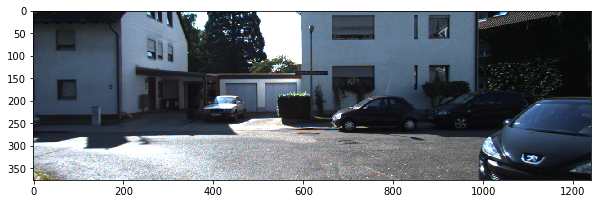

In [8]:
img = cv2.imread(camera_2_img_list[0])
plt.figure(figsize=[10, 10])
plt.imshow(img[..., ::-1])

In [9]:
import torch
from torchvision import models
import numpy as np
from torchvision import transforms
from torchvision.io import read_image
from PIL import Image

In [10]:
weights = models.ResNet18_Weights.IMAGENET1K_V1
model = models.resnet18(weights=weights)

In [11]:
transform=transforms.Compose([transforms.Resize(256), transforms.ToTensor()])

In [12]:
model(transform(Image.open(camera_2_img_list[0])).unsqueeze(0)).shape

torch.Size([1, 1000])

In [15]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [26]:
ret = model.conv1(transform(Image.open(camera_2_img_list[0])).unsqueeze(0))
ret = model.bn1(ret)
ret = model.relu(ret)
ret = model.maxpool(ret)
ret = model.layer1(ret)
ret = model.layer2(ret)
ret = model.layer3(ret)
ret = model.layer4(ret)
ret = model.avgpool(ret)
ret = torch.flatten(ret, 1)
ret = model.fc(ret)

In [27]:
ret.shape

torch.Size([1, 1000])